# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [13]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/pip-req-build-9a433zd4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/j1/c7jjhp9x6qz9464r036f4d5m0000gq/T/pip-req-build-9a433zd4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [14]:
import numpy as np
import torch
#from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.3.0


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [15]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
model, preprocess = clip.load("ViT-B/32")
model.to(device).eval() # CPU, not GPU available locally
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [28]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x177dc8ae0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [29]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [40]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "chopping_board": "a wooden chopping board with chopped veggies and meat.",
    "chopping_board_2": "a wooden chopping board with chopped vegies.",
    "grill_plate": "a grill plate with sliced veggies.",
    "pan_red": "a pan with food.",
    "pan_green": "a pan with veggies.",
    "oven_tray": "an oven tray with sliced zuchini.",
    "bowl_1": "a plate with food",
    "bowl_2": "a plate with food",
}

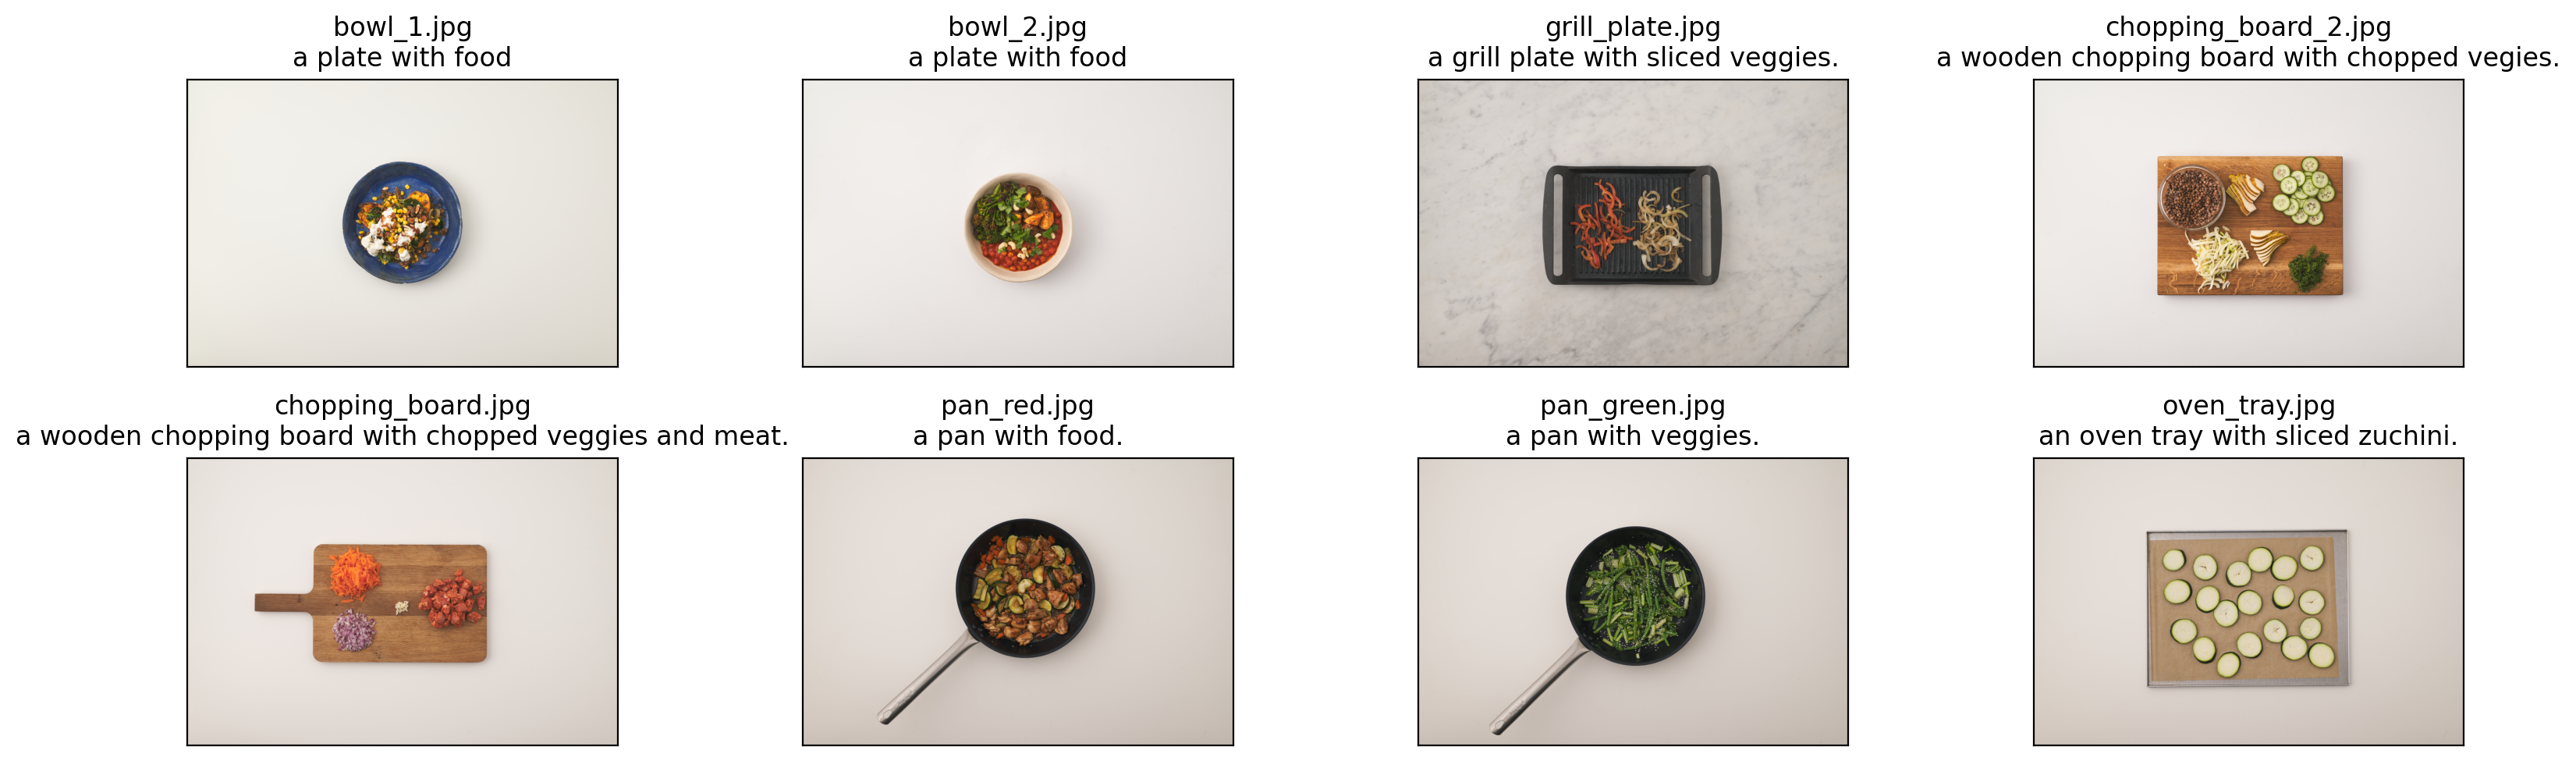

In [41]:
data_dir="toy_dataset"
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [42]:
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)

In [43]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [44]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.to(device).numpy() @ image_features.to(device).numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

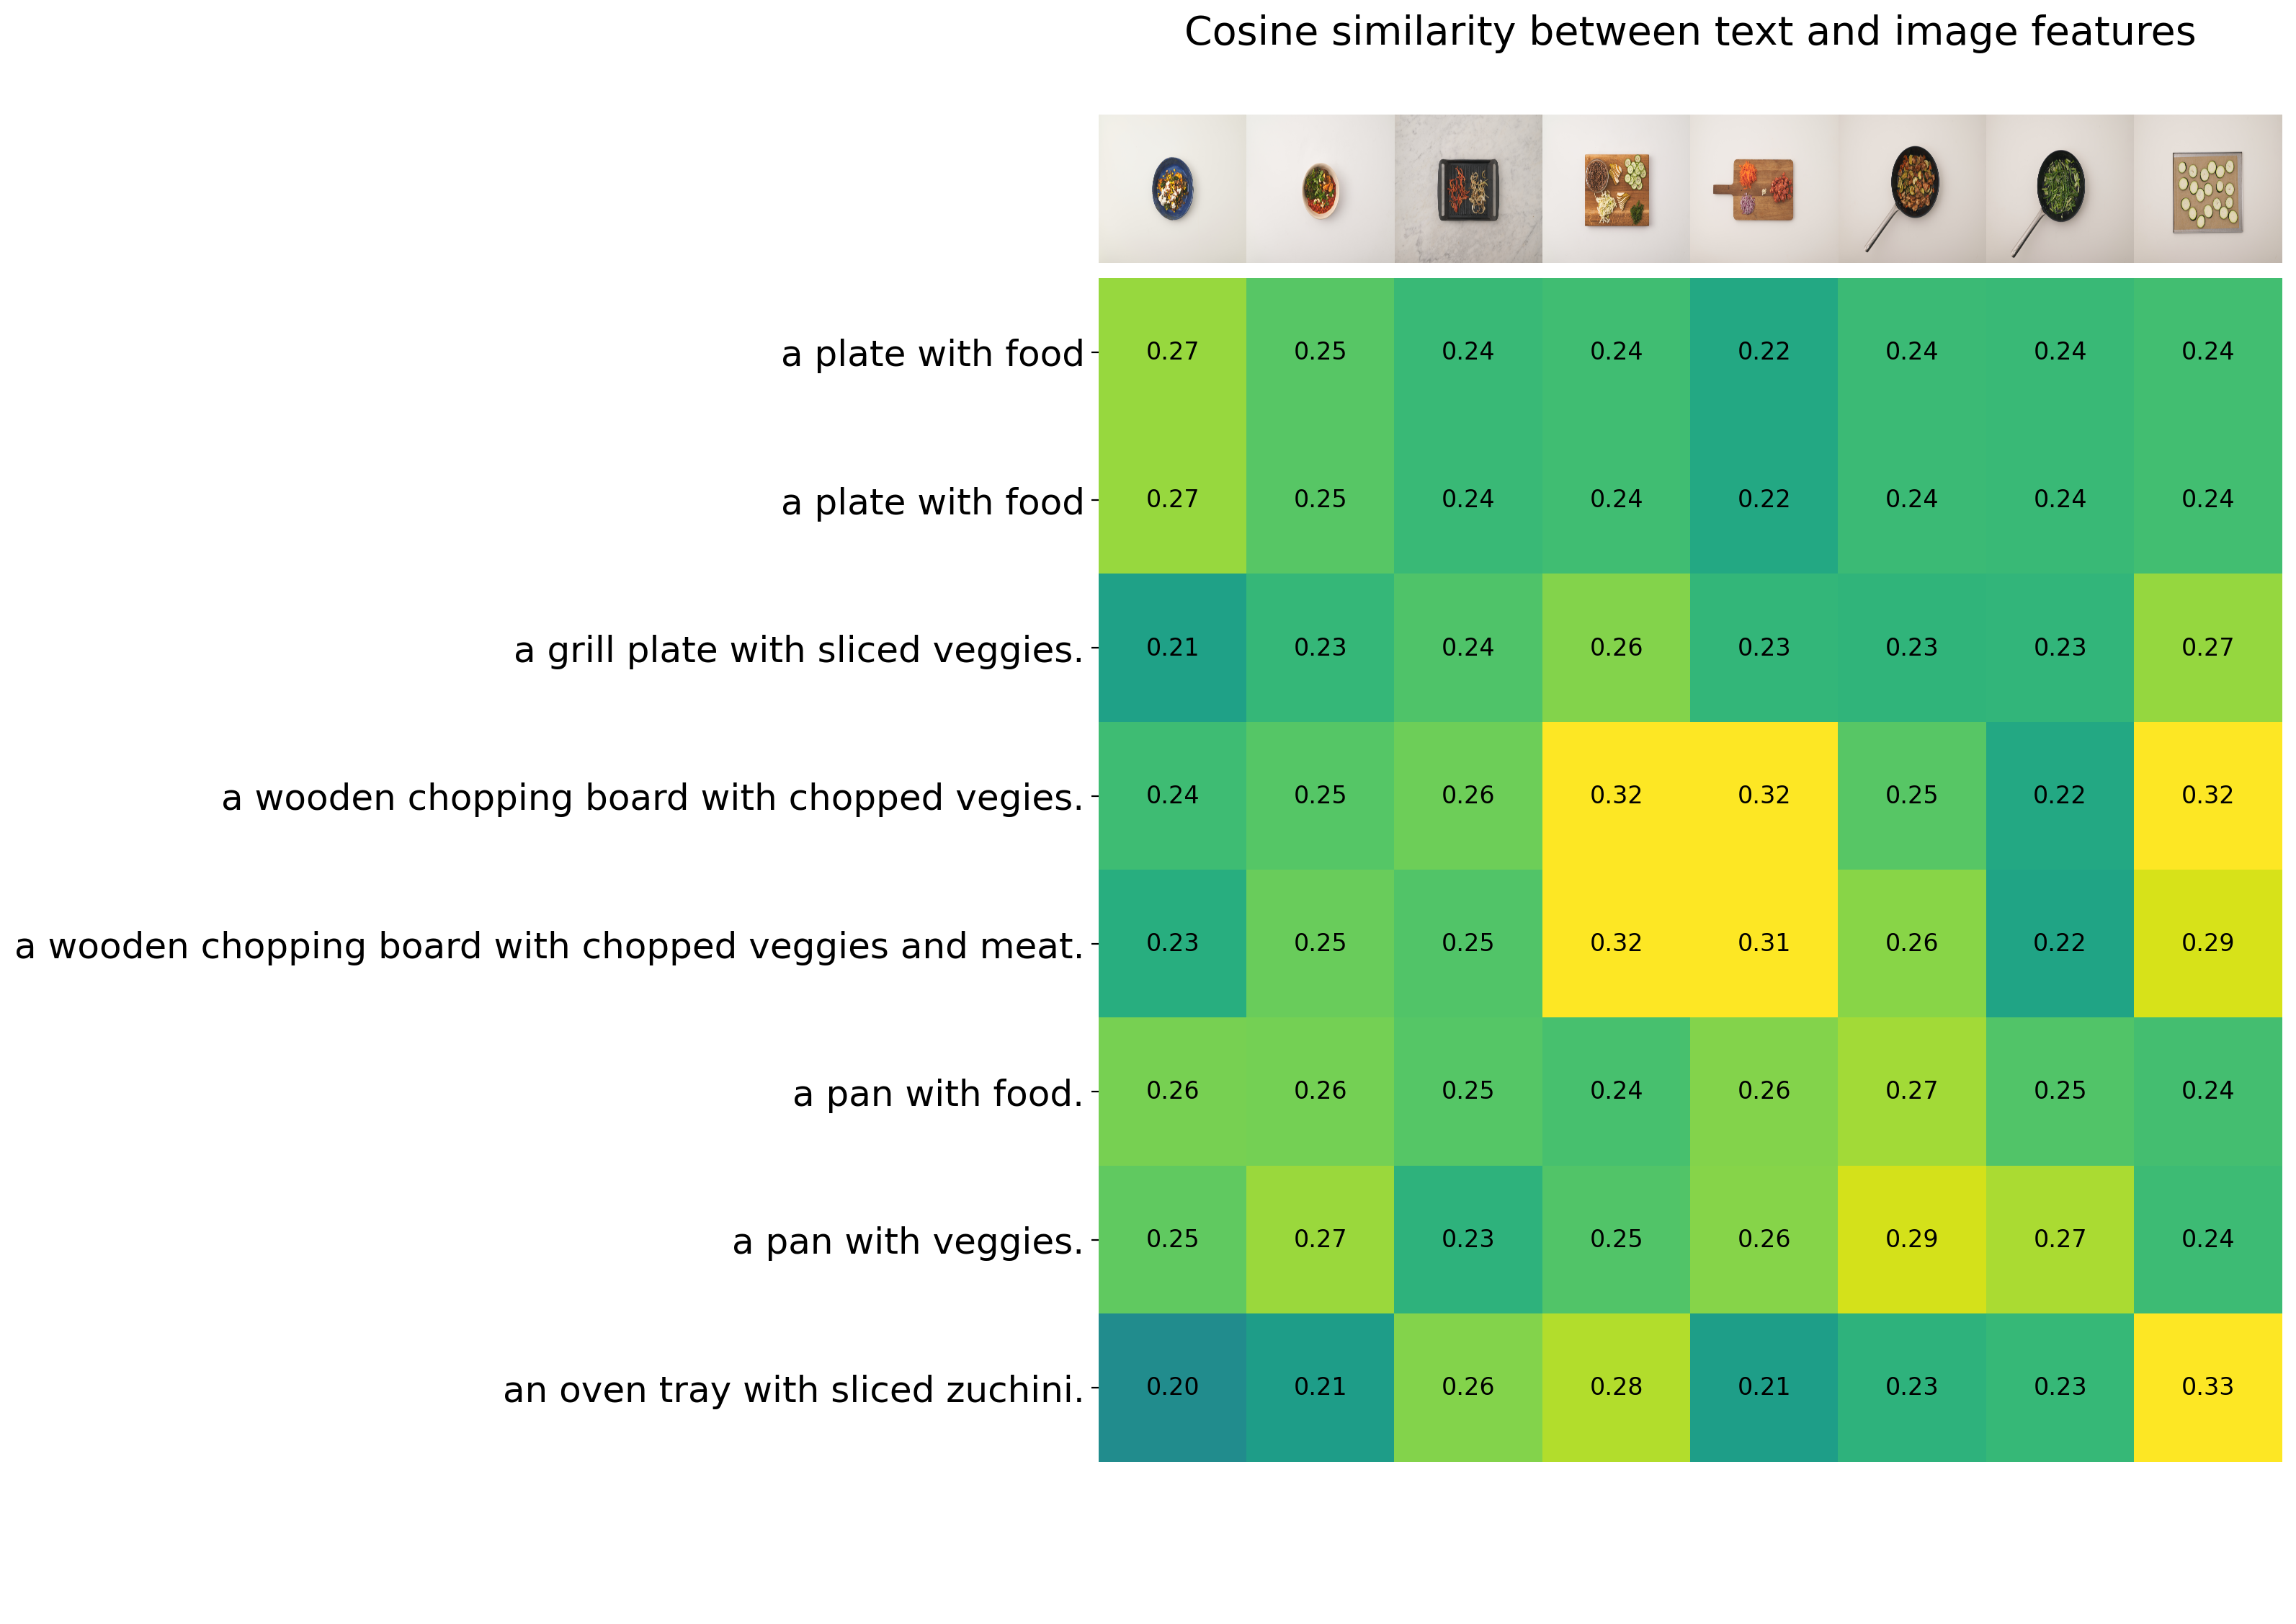

In [45]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

#### CIFAR100

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [47]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:31<00:00, 5292903.57it/s]


Extracting /Users/alejandro.guirau/.cache/cifar-100-python.tar.gz to /Users/alejandro.guirau/.cache


In [49]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

In [50]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

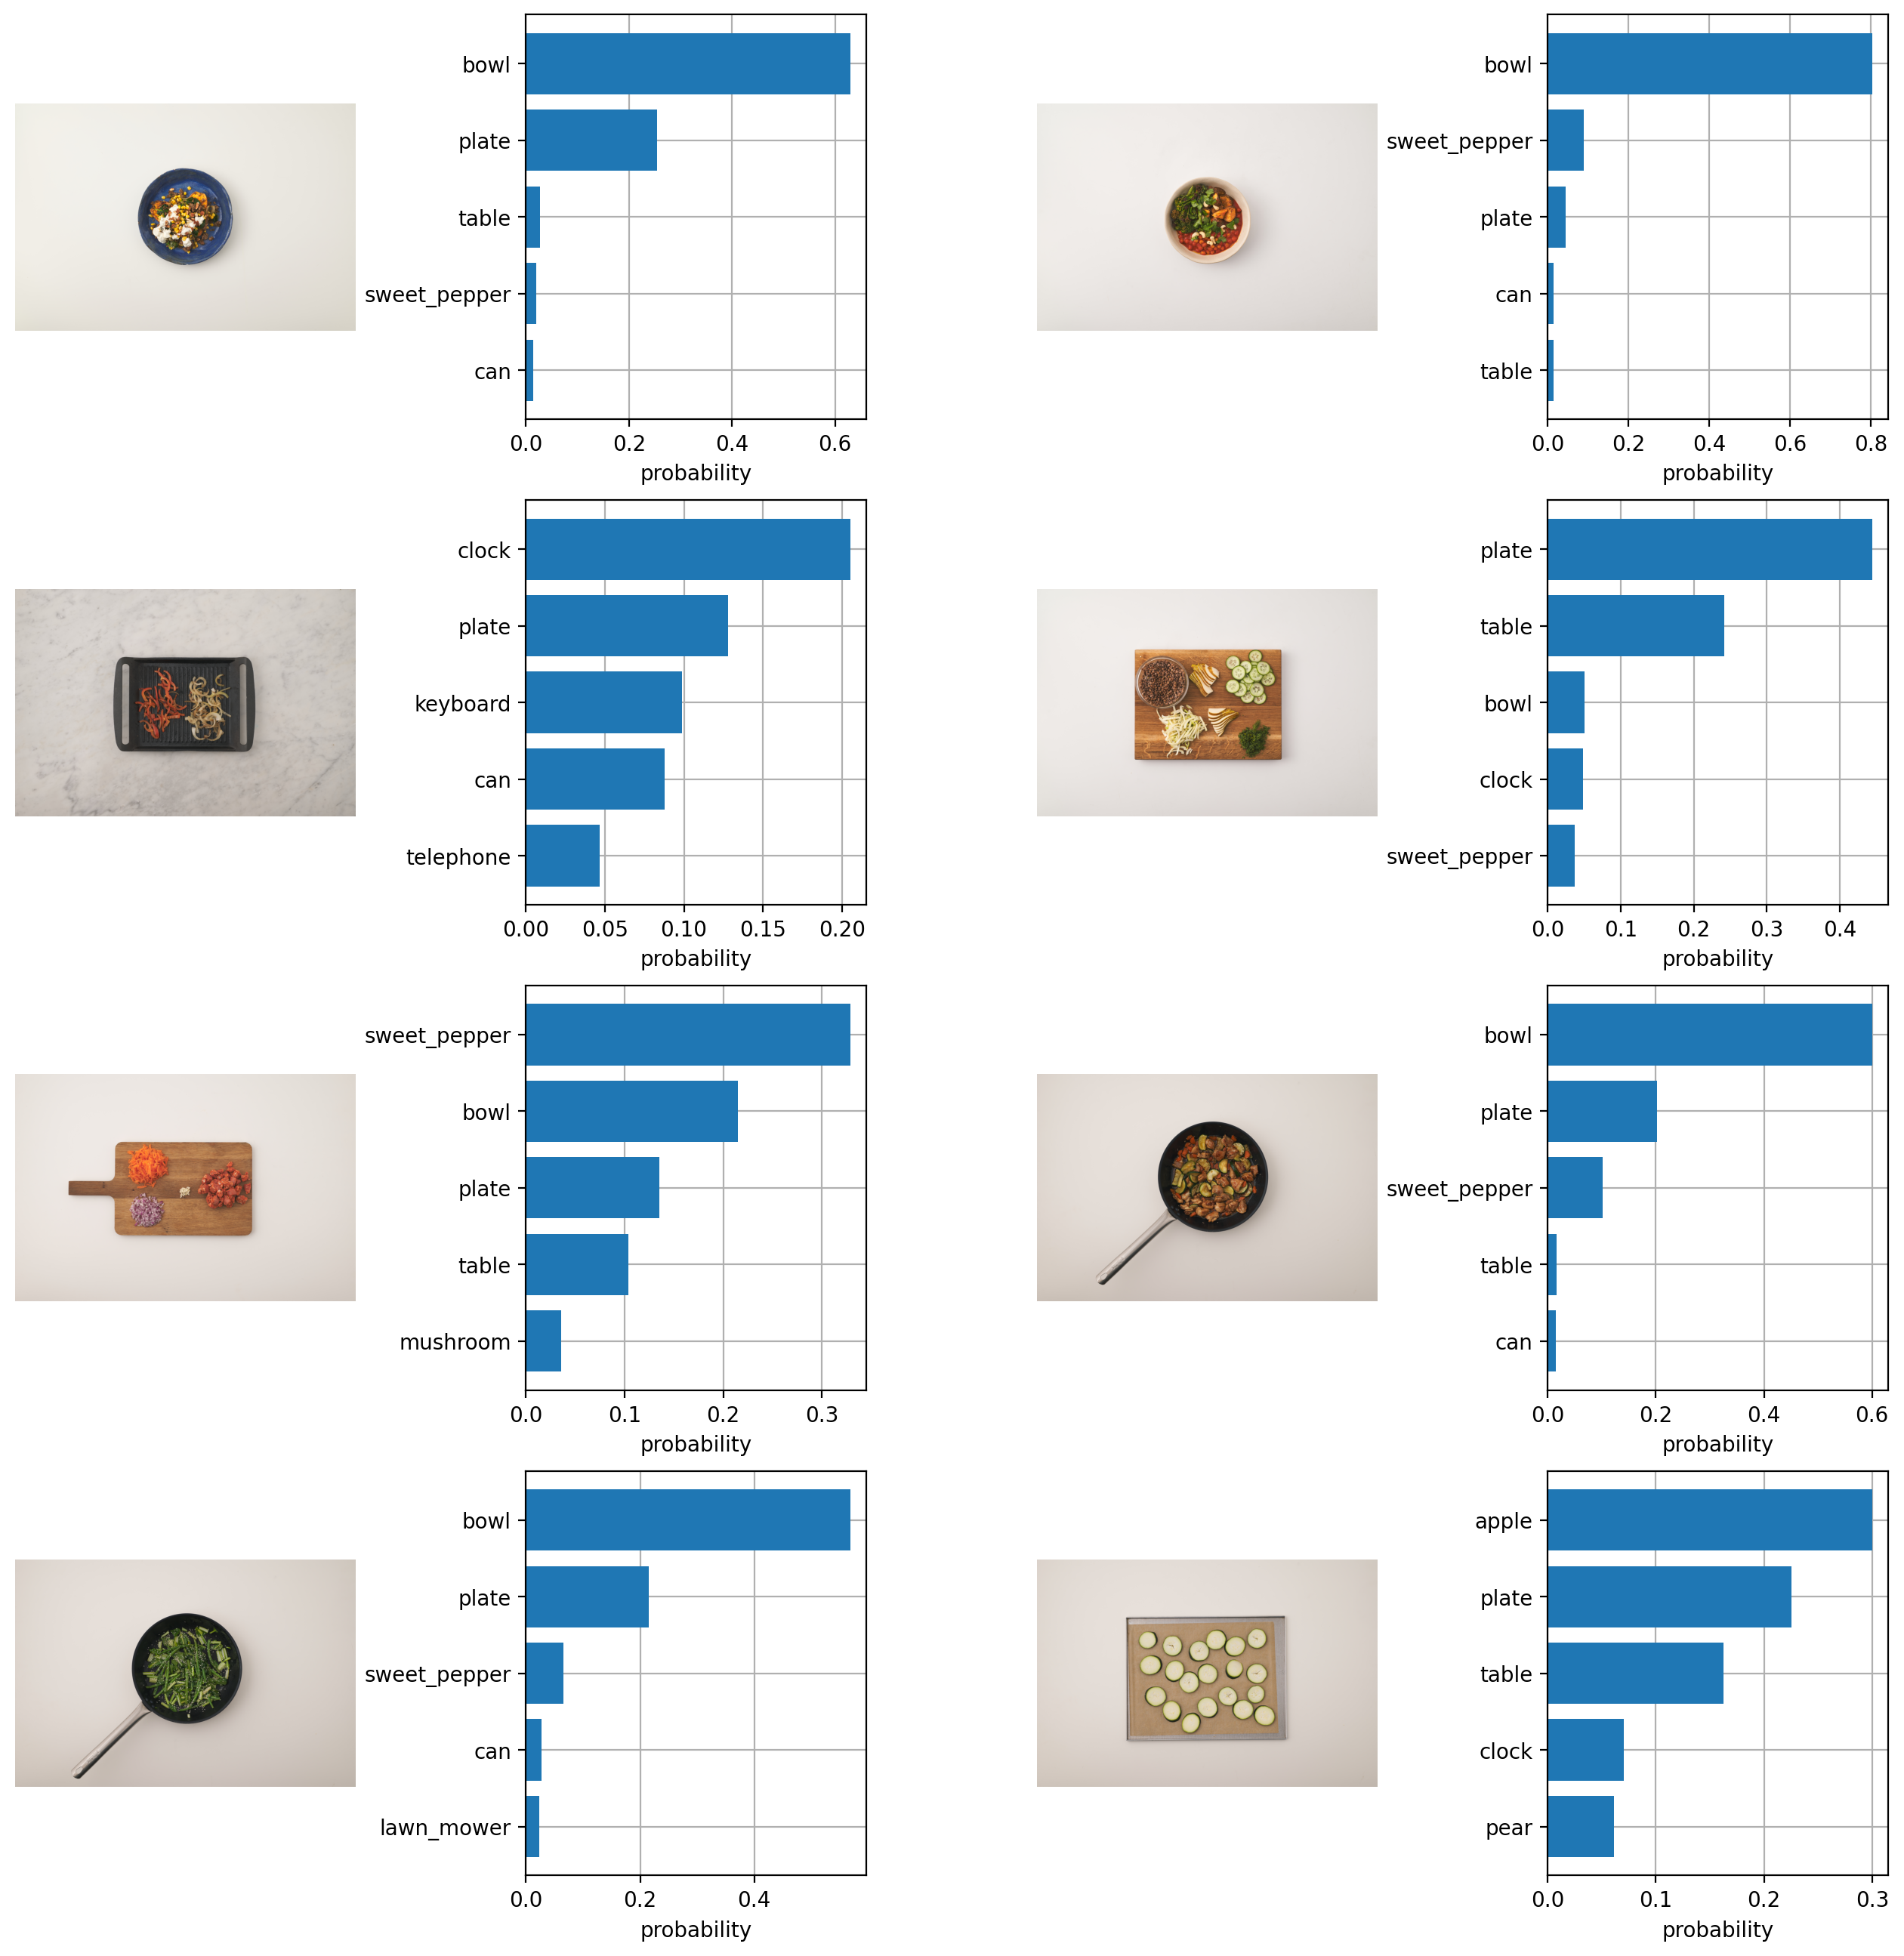

In [51]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

#### Google Open Images Dataset

In [80]:
from torchvision import datasets, transforms

# Use ImageFolder for loading data
dataset = datasets.ImageFolder(root="google_open_images_dataset", transform=preprocess)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # DataLoader without sampler


In [81]:
len(dataset)

110

In [82]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Since the dataset is heavily imbalanced (100 images for "Frying pan" and 10 for "Cutting board")
# Let's use a WeightedRandomSampler to sample the dataset more uniformly

# Calculate the class weights
class_counts = [0] * len(dataset.classes)
for _, label in dataset.samples:
    class_counts[label] += 1
    
# Optional: Print class counts
for i, class_name in enumerate(dataset.classes):
    print(f"{class_name}: {class_counts[i]}")
    
# Calculate weights for each sample
weights = [1.0 / class_counts[label] for _, label in dataset.samples]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(dataset), replacement=True)

# Create DataLoader with WeightedRandomSampler
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

cutting board: 10
frying pan: 100


In [57]:
# Using PyTorch's Custom Dataset Class
from torch.utils.data import Dataset
from PIL import Image
import os

# Won't work yet because it has to understand the folder structure
# Right now just retrieving the folders under the root folder

class OpenImagesDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
dataset = OpenImagesDataset(image_folder="google_open_images_dataset", transform=preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

['google_open_images_dataset/.DS_Store', 'google_open_images_dataset/frying pan', 'google_open_images_dataset/cutting board']


In [83]:
# Sample class labels from dataset
classes = dataset.classes

print(classes)

['cutting board', 'frying pan']


In [84]:
text_descriptions = [f"This is a photo of a {label}" for label in classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

In [85]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [86]:
# Iterate through DataLoader to encode the images and generate image features
with torch.no_grad():
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device) # Move images to GPU or CPU
        
        # Generate image features using the CLIP model
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
            
        # Calculate the cosine similarity between image and text features
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        # Get top-5 predictions for each image in the batch
        top_probs, top_labels = text_probs.to(device).topk(2, dim=-1)
        
        # Log the results
        print(f"Batch {batch_idx + 1}:")
        for i in range(len(images)):
            print(f"Image {i + 1}:")
            for prob, label_idx in zip(top_probs[i], top_labels[i]):
                print(f"  Class: {classes[label_idx]:>16s}, Probability: {prob:.2f}")

Batch 1:
Image 1:
  Class:       frying pan, Probability: 0.99
  Class:    cutting board, Probability: 0.01
Image 2:
  Class:    cutting board, Probability: 1.00
  Class:       frying pan, Probability: 0.00
Image 3:
  Class:    cutting board, Probability: 1.00
  Class:       frying pan, Probability: 0.00
Image 4:
  Class:       frying pan, Probability: 1.00
  Class:    cutting board, Probability: 0.00
Image 5:
  Class:       frying pan, Probability: 0.99
  Class:    cutting board, Probability: 0.01
Image 6:
  Class:       frying pan, Probability: 1.00
  Class:    cutting board, Probability: 0.00
Image 7:
  Class:       frying pan, Probability: 0.97
  Class:    cutting board, Probability: 0.03
Image 8:
  Class:    cutting board, Probability: 1.00
  Class:       frying pan, Probability: 0.00
Image 9:
  Class:    cutting board, Probability: 1.00
  Class:       frying pan, Probability: 0.00
Image 10:
  Class:    cutting board, Probability: 1.00
  Class:       frying pan, Probability: 0.00


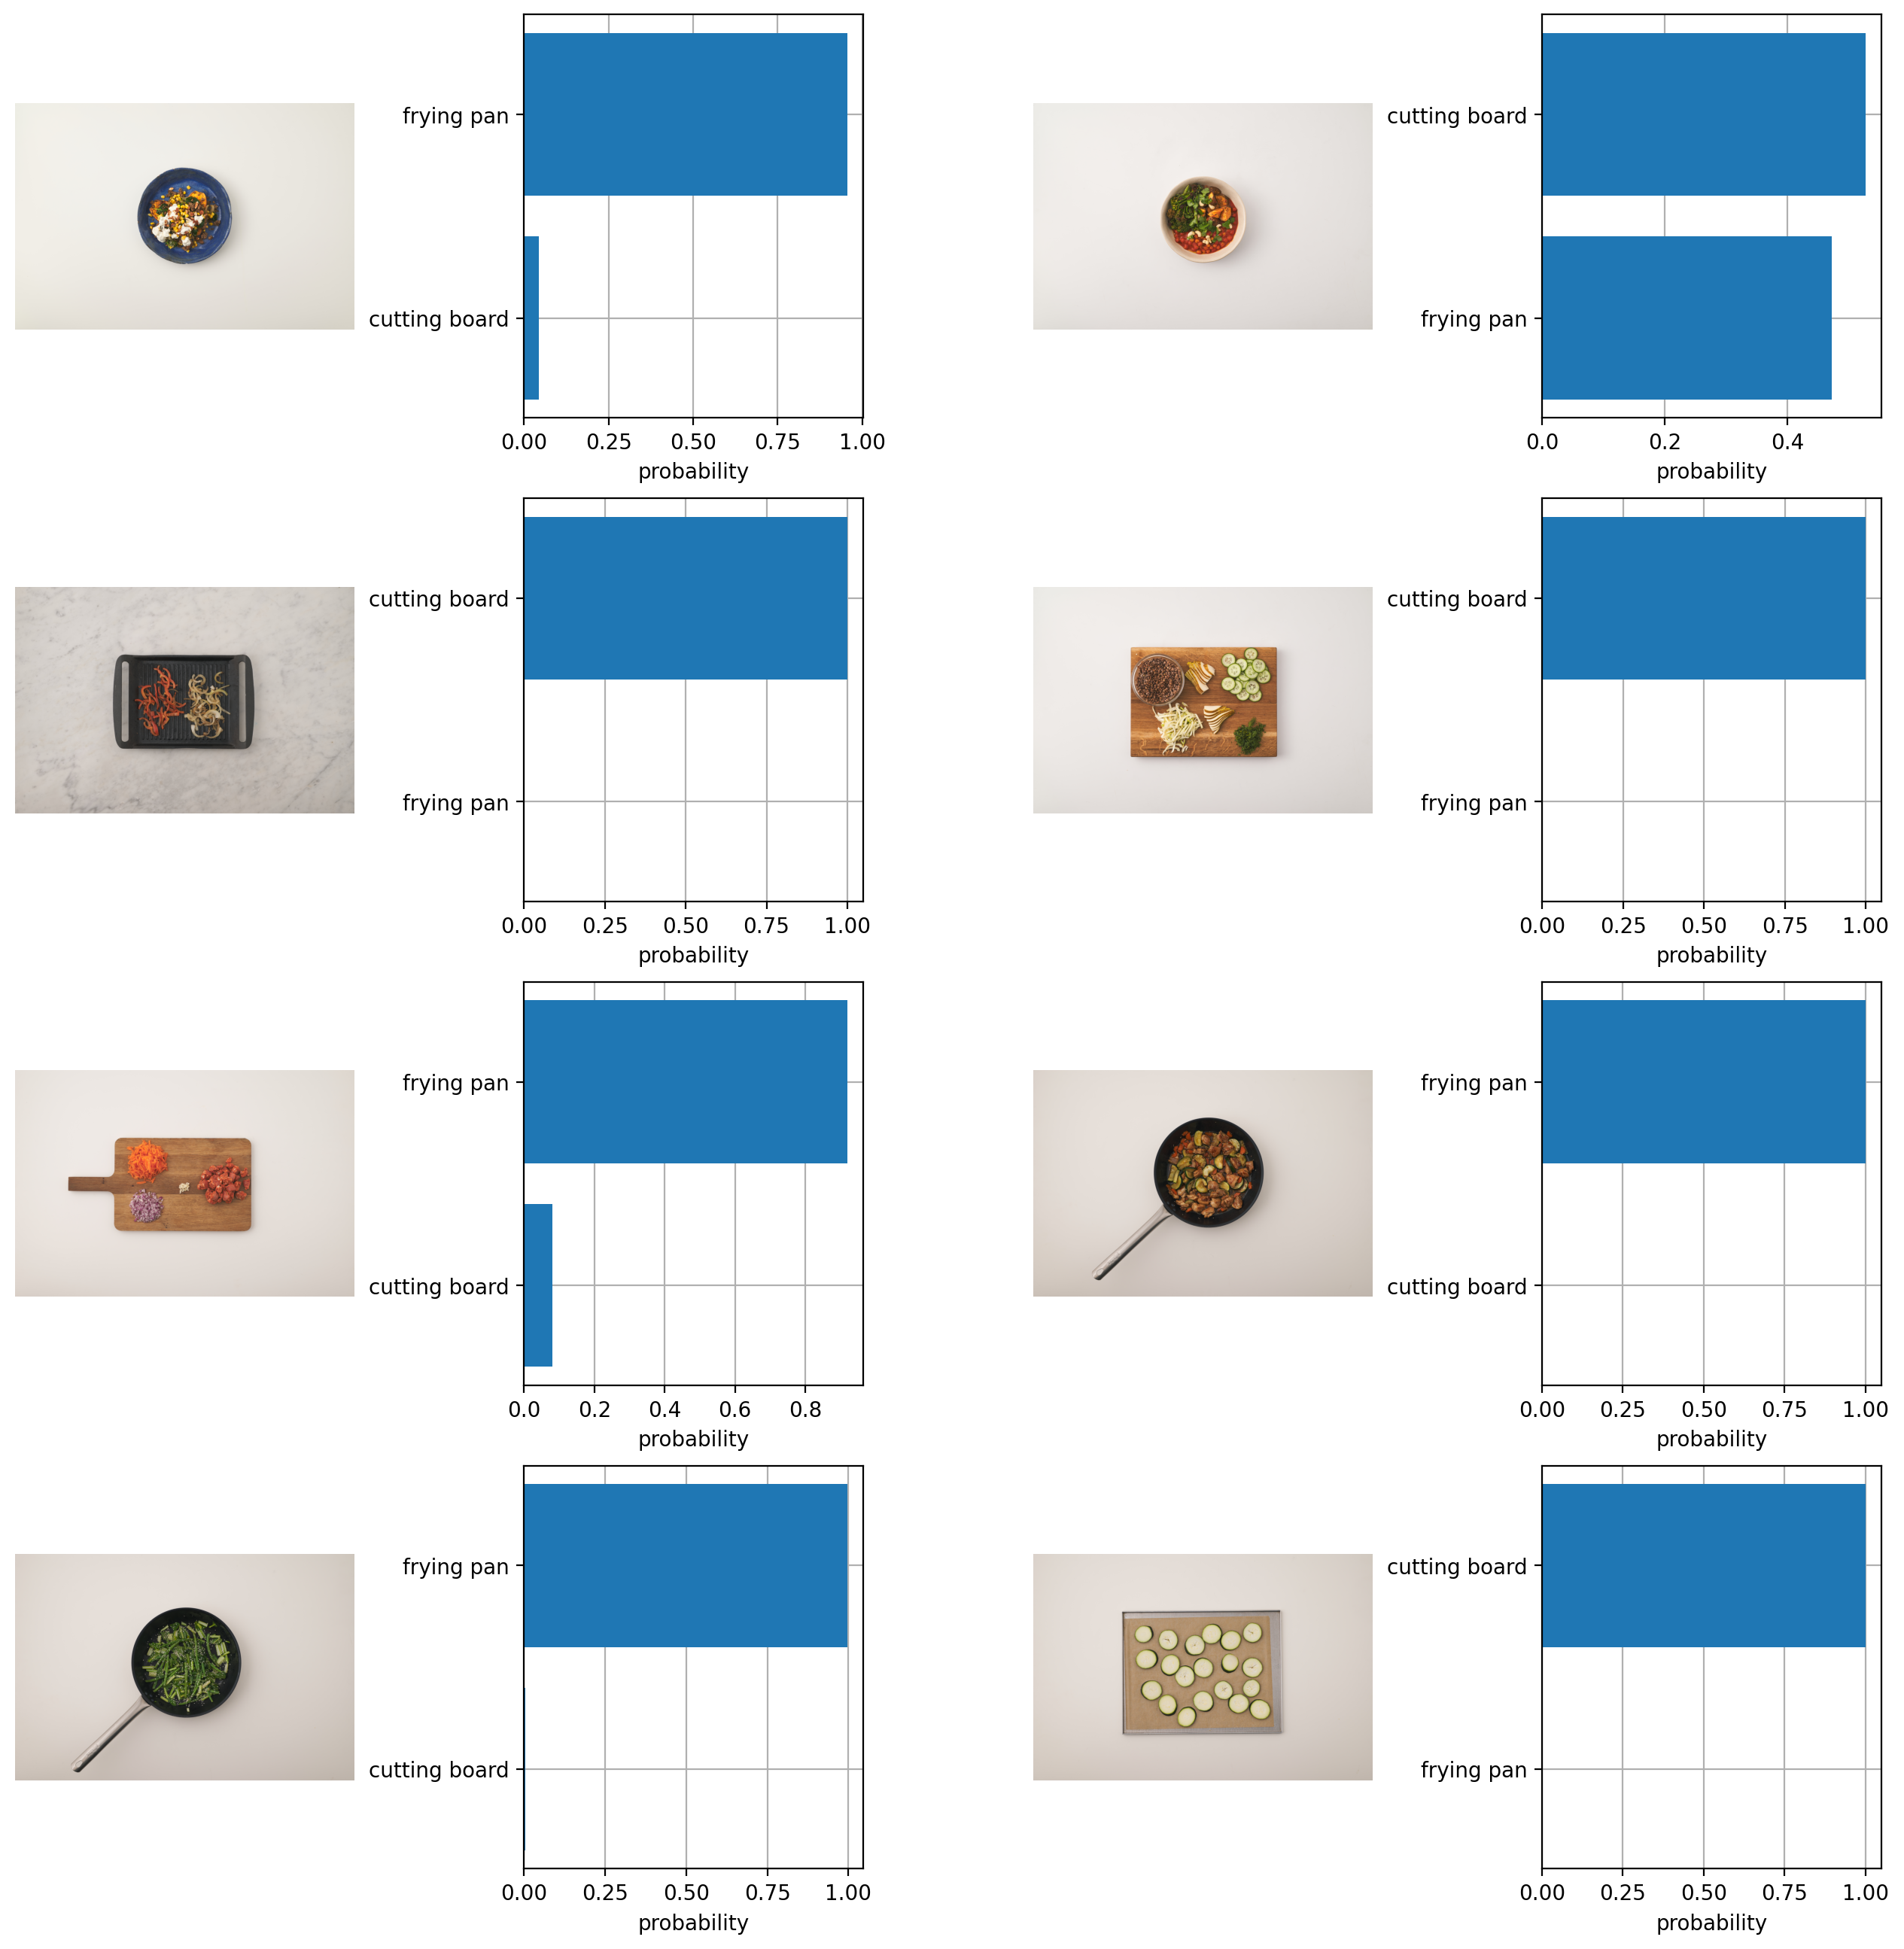

In [87]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()